# Logistic Regression
This notebook focuses on training, testing, and fine-tuning the model. For analysis of the dataset, please refer to the analysis notebook.

1. [Importing Necessary Libraries and Dataset](#importing-necessary-libraries-and-dataset)
2. [Preprocessing](#preprocessing)
3. [Training Model](#training-model)
    - [Cross Validation](#cross-validation)
    - [Evaluation of Model](#evaluation-of-model)
4. [Testing Model](#testing-model)
    - [Predicting on Test Set](#predicting-on-test-set)
    - [Evaluation of Model](#evaluation-of-test-model)
5. [Fine Tuning Model](#fine-tuning-model)
    - [GridSearch](#gridsearch)
    - [Evaluation of Model](#evaluation-of-fine-tuned-model)


# Chapter 1 - Import Libraries and Dataset
This chapter involves importing necessary libraries such as:
1. pandas
2. numpy
3. matplotlib
    - Plotting graphs
4. seaborn 
    - Plotting graphs
5. typing
    - Type indicate

The dataset is also imported in this chapter

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import typing

In [39]:
cardio_df:pd.DataFrame = pd.read_csv("dataset.csv")
cardio_df.head()

,Gender,Age,Height(cm),Weight(kg),Family_history,Alcohol,Junk_food,Vege_day,Meals_day,Snack,Smoking,Water_intake(L),Transportation,Exercise,TV,Income,Discipline,Cardiovascular_risk(y)
0,Female,42,172.2,82.9,no,low,yes,3,3,Sometimes,no,2.72,car,3,rare,2081,no,medium
1,Female,19,175.3,80.0,yes,none,yes,2,1,Sometimes,no,2.65,bus,3,moderate,5551,no,medium
2,Female,43,158.3,81.9,yes,none,yes,3,1,Sometimes,no,1.89,car,1,rare,14046,no,high
3,Female,23,165.0,70.0,yes,low,no,2,1,Sometimes,no,2.00,bus,0,rare,9451,no,medium
4,Male,23,169.0,75.0,yes,low,yes,3,3,Sometimes,no,2.82,bus,1,often,17857,no,medium


# Chapter 2 - Preprocessing
This chapter involves:
1. [Adjusting the features](#features)
2. [Removing outliers ](#removing-outliers)
3. [Splitting dataset into training set and test set](#splitting-dataset)
4. [Processing Features](#features)
    - Combining features
    - Discretising feature
5. [Creating encoders](#encoders)
6. [Transforming data](#transformers)
7. [Preprocessing datasets](#preprocessing-datasets)


## Features

In [40]:
# Combining Weight and Height to form BMI
cardio_df['BMI'] = (cardio_df['Weight(kg)']/ np.square(cardio_df['Height(cm)']/100)).apply(lambda x:round(x,2))
def discretise_age(data:pd.DataFrame)->None:
    data['age_cat'] = pd.cut(data['Age'], bins = [13, 20, 25, 30, data['Age'].max()], labels=[1,2,3,4])

## Removing outliers

In [41]:
# Define a function to remove outliers using the IQR method
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Apply outlier removal for all numerical columns
numerical_columns = ['Age', 'Height(cm)', 'Weight(kg)', 'Exercise']

# Removing outliers from the dataset
cleaned_data = cardio_df.copy()
for col in numerical_columns:
    cleaned_data = remove_outliers_iqr(cleaned_data, col)

# Display the number of rows removed due to outliers
removed_rows = len(cardio_df) - len(cleaned_data)
removed_rows, cleaned_data.head()

(159,
    Gender  Age  Height(cm)  Weight(kg) Family_history Alcohol Junk_food  \
 1  Female   19       175.3        80.0            yes    none       yes   
 3  Female   23       165.0        70.0            yes     low        no   
 4    Male   23       169.0        75.0            yes     low       yes   
 5    Male   23       172.0        82.0            yes     low       yes   
 6  Female   21       172.0       133.9            yes     low       yes   
 
    Vege_day  Meals_day      Snack Smoking  Water_intake(L) Transportation  \
 1         2          1  Sometimes      no             2.65            bus   
 3         2          1  Sometimes      no             2.00            bus   
 4         3          3  Sometimes      no             2.82            bus   
 5         2          1  Sometimes      no             1.00            bus   
 6         3          3  Sometimes      no             2.42            bus   
 
    Exercise        TV  Income Discipline Cardiovascular_risk(y)  

In [42]:
cardio_df = cleaned_data

## Splitting Dataset

In [43]:
from sklearn.model_selection import train_test_split

# Splitting the features and label from the original dataset
X_cardio_df:pd.DataFrame = cardio_df.drop(columns = 'Cardiovascular_risk(y)')
y_cardio_df:pd.Series= cardio_df['Cardiovascular_risk(y)']

# Extracting the training set and test set
X_train, X_test, y_train, y_test = train_test_split(X_cardio_df, y_cardio_df, test_size=0.2, random_state= 42, stratify=  y_cardio_df)

## Encoders

In [44]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelBinarizer

# Create encoders
def fit_encoders(X_data:pd.DataFrame, y_data:pd.Series)->tuple[LabelBinarizer, 
                                                            LabelBinarizer, 
                                                            LabelBinarizer, 
                                                            LabelBinarizer, 
                                                            LabelBinarizer,
                                                            OneHotEncoder, 
                                                            OrdinalEncoder, 
                                                            OrdinalEncoder]:
    cardiovascular_categories:list[str] = [['low', 'medium', 'high']]
    lifestyle_categories:list[list[str]] = [
        ['none', 'low', 'medium', 'high'],
        ['rare', 'moderate', 'often'],
        ['No', 'Sometimes', 'Frequently', 'Always']
        ]
    one_encoder:OneHotEncoder = OneHotEncoder(sparse_output=False)
    ordinal_encoder:OrdinalEncoder = OrdinalEncoder(categories=lifestyle_categories)   
    label_ordinal_encoder:OrdinalEncoder = OrdinalEncoder(categories=cardiovascular_categories)

    lb_gender:LabelBinarizer = LabelBinarizer()
    lb_gender.fit(X_data['Gender'])

    lb_family:LabelBinarizer = LabelBinarizer()
    lb_family.fit(X_data['Family_history'])

    lb_junk_food:LabelBinarizer = LabelBinarizer()
    lb_junk_food.fit(X_data['Junk_food'])

    lb_smoking:LabelBinarizer = LabelBinarizer()
    lb_smoking.fit(X_data['Smoking'])

    lb_discipline:LabelBinarizer = LabelBinarizer()
    lb_discipline.fit(X_data['Discipline'])

    one_encoder.fit(X_data[['Transportation']])
    ordinal_encoder.fit(X_data[['Alcohol', 'TV', 'Snack']])

    label_ordinal_encoder.fit(pd.DataFrame(y_data))

    return (lb_gender, lb_family, lb_junk_food, lb_smoking, lb_discipline, one_encoder, ordinal_encoder, label_ordinal_encoder)


## Transformers

In [45]:
def transform_data(X_data:pd.DataFrame,
                    y_data:pd.Series, 
                    lb_gender:LabelBinarizer, 
                    lb_family:LabelBinarizer, 
                    lb_junk_food:LabelBinarizer, 
                    lb_smoking:LabelBinarizer, 
                    lb_discipline:LabelBinarizer, 
                    one_encoder:OneHotEncoder, 
                    ordinal_encoder:OrdinalEncoder, 
                    label_ordinal_encoder:OrdinalEncoder)->tuple[np.array, np.array]:
    
    gender_encoded:np.array = lb_gender.transform(X_data['Gender'])
    family_encoded:np.array = lb_family.transform(X_data['Family_history'])
    junk_food_encoded:np.array = lb_junk_food.transform(X_data['Junk_food'])
    smoking_encoded:np.array = lb_smoking.transform(X_data['Smoking'])
    disicipline_encoded:np.array = lb_discipline.transform(X_data['Discipline'])

    transport_encoded:np.array = one_encoder.transform(X_data[['Transportation']])
    ordinal_encoded:np.array = ordinal_encoder.transform(X_data[['Alcohol', 'TV', 'Snack']])

    categorical_encoded:np.array = np.concatenate([gender_encoded, family_encoded, junk_food_encoded, smoking_encoded, disicipline_encoded, transport_encoded, ordinal_encoded, X_data[['age_cat']]], axis=1)
    numerical:np.array = X_data[['BMI' , 'Exercise']].to_numpy()
    X_processed:np.array = np.concatenate([numerical, categorical_encoded], axis=1)
    
    y_processed:np.array = label_ordinal_encoder.transform(pd.DataFrame(y_data)).ravel()

    return X_processed, y_processed


## Preprocessing datasets

In [46]:
discretise_age(X_train)
# Retrieving the encoders
lb_gender, lb_family, lb_junk_food, lb_smoking, lb_discipline, one_encoder, ordinal_encoder, label_ordinal_encoder = fit_encoders(X_train, y_train)

# Processing the training set
X_train_processed , y_train_processed = transform_data(X_train, y_train, lb_gender, lb_family, lb_junk_food, lb_smoking, lb_discipline, one_encoder, ordinal_encoder, label_ordinal_encoder)

### Discretised Age

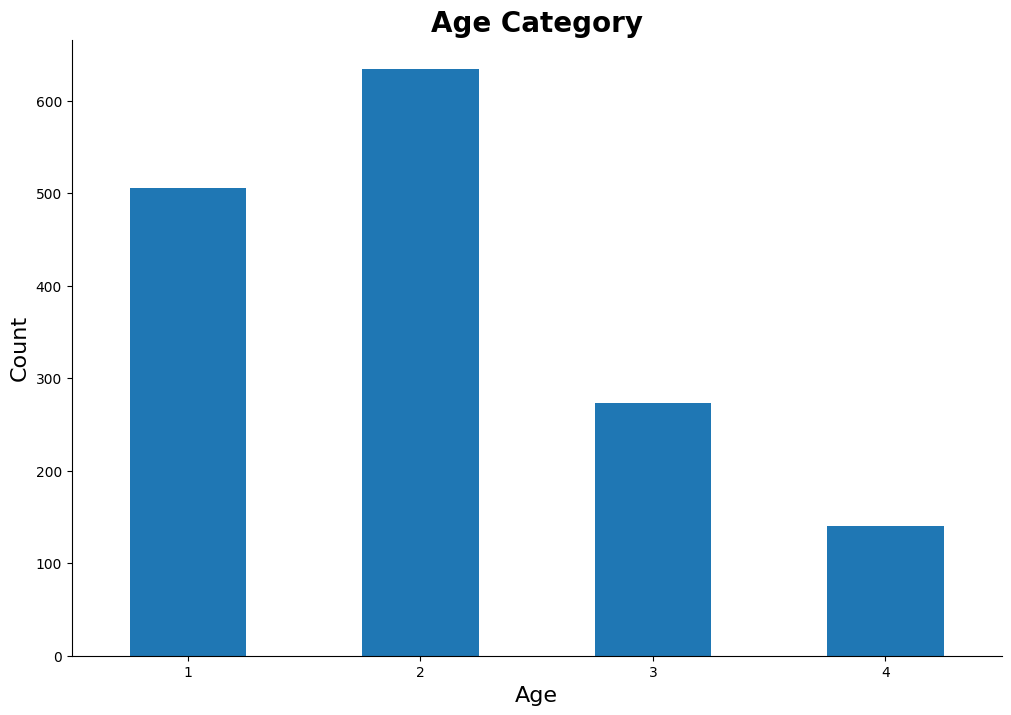

In [47]:
ax = X_train['age_cat'].value_counts().sort_index().plot.bar(figsize=(12,8))
ax.set_ylabel("Count", fontsize = 16)
ax.set_xlabel("Age", fontsize = 16)
ax.set_title("Age Category", fontweight='bold', fontsize = 20)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.spines[['right', 'top']].set_visible(False)
plt.show()

# Chapter 3 - Training model
This chapter involves:
1. [Performing k-fold cross validation](#k-fold-cross-validation)
2. [Evaluation of the training model](#evaluation-of-training-model)
    - Classification report
    - Confusion Matrix
    - ROC-AUC graph
    - Learning Curve
      

## K-fold cross validation

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.multiclass import OneVsRestClassifier

# Initialize the StratifiedKFold object
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store the cross-validation scores
cv_accuracy_score = []
cv_precision_score = []  
cv_recall_score = []
cv_f1_score = []

# Perform Stratified K-Fold Cross-Validation
for train_index, val_index in skf.split(X_train_processed, y_train_processed):
    # Split the data into training and validation sets for the current fold
    X_train_fold, X_val_fold = X_train_processed[train_index], X_train_processed[val_index]
    y_train_fold, y_val_fold = y_train_processed[train_index], y_train_processed[val_index]

    # Initialize the OneVsRestClassifier with LogisticRegression
    model = OneVsRestClassifier(LogisticRegression(solver='lbfgs', max_iter=5000, penalty='l2', class_weight='balanced'))

    # Fit the model with the training data of the current fold
    model.fit(X_train_fold, y_train_fold)

    # Predict using the validation data of the current fold
    y_pred = model.predict(X_val_fold)

    # Calculate accuracy, precision, and F1 score
    accuracy = accuracy_score(y_val_fold, y_pred)
    precision = precision_score(y_val_fold, y_pred, average='weighted')
    recall = recall_score(y_val_fold, y_pred, average='weighted')
    f1 = f1_score(y_val_fold, y_pred, average='weighted')

    
    # Append the scores to the corresponding lists
    cv_accuracy_score.append(accuracy)
    cv_precision_score.append(precision)
    cv_recall_score.append(recall)
    cv_f1_score.append(f1)
    
    
# Print the cross-validation accuracy scores
print(f'Cross-Validation Accuracy Scores: {cv_accuracy_score}')
print(f'Average Accuracy: {sum(cv_accuracy_score) / len(cv_accuracy_score)}')
print()

# Print the cross-validation precision scores
print(f'Cross-Validation Precision Scores: {cv_precision_score}')
print(f'Average Precision: {sum(cv_precision_score) / len(cv_precision_score)}')
print()

#Print the cross-validation recall scores
print(f'Cross-Validation Recall Scores:{list(map(float,cv_recall_score))}')
print(f'Average Recall: {sum(cv_recall_score) / len(cv_recall_score)}')
print()

# Print the cross-validation F1 scores
print(f'Cross-Validation F1 Scores: {cv_f1_score}')
print(f'Average F1 score: {sum(cv_f1_score) / len(cv_f1_score)}')

Cross-Validation Accuracy Scores: [0.977491961414791, 0.9935691318327974, 0.9870967741935484, 0.9838709677419355, 0.9838709677419355]
Average Accuracy: 0.9851799605850016

Cross-Validation Precision Scores: [np.float64(0.9774732279819921), np.float64(0.9935691318327974), np.float64(0.9874423963133642), np.float64(0.983815331010453), np.float64(0.9839490968801314)]
Average Precision: 0.9852498368037477

Cross-Validation Recall Scores:[0.977491961414791, 0.9935691318327974, 0.9870967741935484, 0.9838709677419355, 0.9838709677419355]
Average Recall: 0.9851799605850016

Cross-Validation F1 Scores: [np.float64(0.97744180336778), np.float64(0.9935691318327974), np.float64(0.9870272108248518), np.float64(0.9838278729017544), np.float64(0.9838916084880929)]
Average F1 score: 0.9851515254830552


## Evaluation of Training Model

In [49]:
#Model evaluation
final_model: LogisticRegression = OneVsRestClassifier(LogisticRegression(solver='lbfgs', max_iter=5000, penalty='l2', class_weight='balanced'))
final_model.fit(X_train_processed, y_train_processed)
y_train_pred:np.array = final_model.predict(X_train_processed)

accuracy:float = accuracy_score(y_train_processed, y_train_pred)
f1:float = f1_score(y_train_processed, y_train_pred, average='weighted')
recall:float = recall_score(y_train_processed, y_train_pred,  average='weighted')
precision:float = precision_score(y_train_processed, y_train_pred, average='weighted')

In [50]:
print(f'Model evaluation after training with the training set:')
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 score: {f1}')

Model evaluation after training with the training set:
Accuracy: 0.9922680412371134
Precision: 0.9922562076504403
Recall: 0.9922680412371134
F1 score: 0.9922596724505841


### Classification report

In [51]:
from sklearn.metrics import classification_report
# Classification report for the training set
report = classification_report(y_train_processed, y_train_pred, target_names=['low', 'medium', 'high'])
print(report)

              precision    recall  f1-score   support

         low       0.99      0.99      0.99       439
      medium       0.99      0.98      0.99       417
        high       1.00      1.00      1.00       696

    accuracy                           0.99      1552
   macro avg       0.99      0.99      0.99      1552
weighted avg       0.99      0.99      0.99      1552



### Confusion Matrix

<Figure size 1200x800 with 0 Axes>

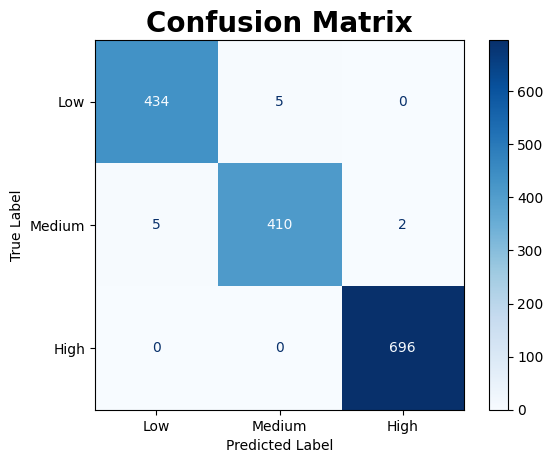

In [52]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cm = confusion_matrix(y_train_processed, y_train_pred, labels=[0.0, 1.0, 2.0])
plt.figure(figsize=(12, 8))

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Low", "Medium", "High"])
disp.plot(cmap=plt.cm.Blues)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix', fontsize=20, fontweight='bold')
plt.show()

### ROC-AUC Curve

AUC = 0.9970
AUC = 0.9898
AUC = 0.9980


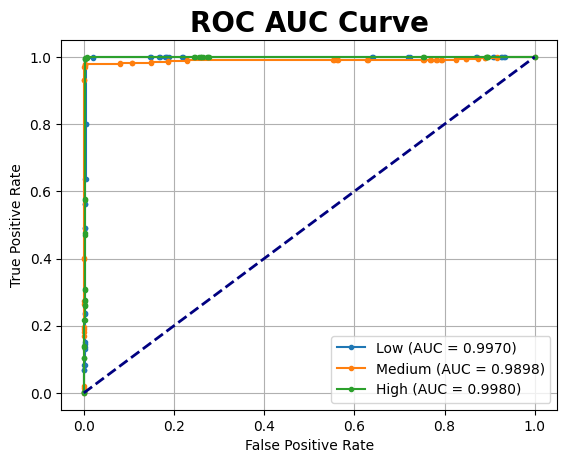

In [53]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Predict probabilities for each class using cross-validation
y_pred_proba = cross_val_predict(final_model, X_train_processed, y_train_processed, cv=5, method='predict_proba')

label = ['Low', 'Medium', 'High'] 

# Compute ROC curve and ROC AUC score (One-vs-Rest for multiclass)
for i in range(y_pred_proba.shape[1]):
    fpr_1, tpr_1, _ = roc_curve(y_train_processed == i, y_pred_proba[:, i])
    auc_1 = roc_auc_score(y_train_processed == i, y_pred_proba[:, i])
    plt.plot(fpr_1, tpr_1, marker='.', label=f'{label[i]} (AUC = {auc_1:.4f})')
    print('AUC = {:.4f}'.format(auc_1))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('ROC AUC Curve', fontsize=20, fontweight='bold')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc ='lower right')
plt.grid(True)
plt.legend()
plt.show()


### Learning Curve

Text(0.5, 1.0, 'Training Learning Curve')

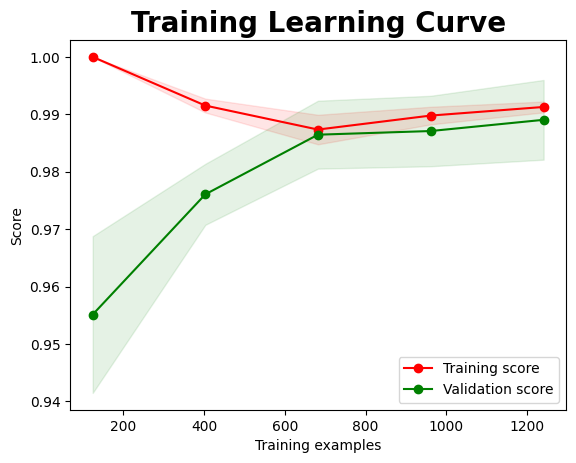

In [54]:
from sklearn.model_selection import learning_curve
train_sizes, train_scores, val_scores = learning_curve(final_model, X_train_processed, y_train_processed, cv=5, scoring='f1_weighted')

train_scores_mean = train_scores.mean(axis=1)
train_scores_std = train_scores.std(axis=1)
val_scores_mean = val_scores.mean(axis=1)
val_scores_std = val_scores.std(axis=1)

plt.figure()
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, val_scores_mean, 'o-', color='g', label='Validation score')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, val_scores_mean - val_scores_std, val_scores_mean + val_scores_std, alpha=0.1, color='g')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.legend(loc='best')
plt.title('Training Learning Curve', fontsize=20, fontweight='bold')


# Chapter 4 - Testing model
This chapter involves:
1. [Testing model on test set](#predicting-on-test-set)
2. [Evaluation of the model on test set](#evaluation-of-test-model)
    - Classification Report
    - Confusion Matrix
    - ROC-AUC graph

## Predicting on Test Set

In [55]:
#Testing model
discretise_age(X_test)

X_test_processed , y_test_processed = transform_data(X_test, y_test, lb_gender, lb_family, lb_junk_food, lb_smoking, lb_discipline, one_encoder, ordinal_encoder, label_ordinal_encoder)

y_test_pred:np.array = final_model.predict(X_test_processed)

test_accuracy:float = accuracy_score(y_test_processed, y_test_pred)
test_f1_score:float = f1_score(y_test_processed, y_test_pred, average='weighted')
test_precision:float = precision_score(y_test_processed, y_test_pred, average='weighted')
test_recall:float = recall_score(y_test_processed, y_test_pred, average='weighted')

## Evaluation of Test Model

In [56]:
print(f'Testing evalution: ')
print(f'Accuracy: {test_accuracy}')
print(f'Precision: {test_precision}')
print(f'Recall: {test_recall}')
print(f'F1 score: {test_f1_score}')

Testing evalution: 
Accuracy: 0.9897172236503856
Precision: 0.9897082455173656
Recall: 0.9897172236503856
F1 score: 0.9897032781140256


### Classification report

In [57]:
from sklearn.metrics import classification_report
# Classification report for the test set
report = classification_report(y_test_processed, y_test_pred, target_names=['low', 'medium', 'high'])
print(report)

              precision    recall  f1-score   support

         low       0.99      0.98      0.99       110
      medium       0.98      0.98      0.98       104
        high       0.99      1.00      1.00       175

    accuracy                           0.99       389
   macro avg       0.99      0.99      0.99       389
weighted avg       0.99      0.99      0.99       389



### Confusion Matrix

<Figure size 1200x800 with 0 Axes>

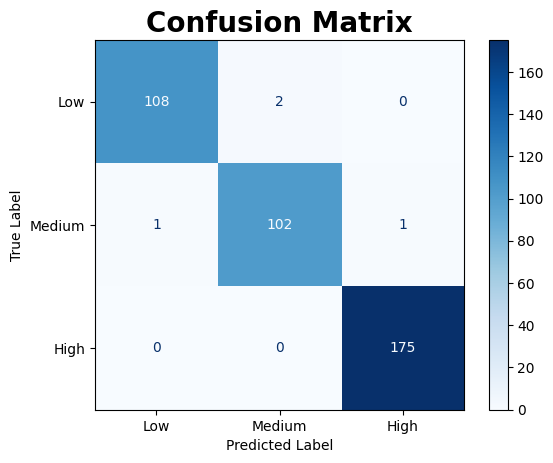

In [58]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix


# Compute confusion matrix
cm = confusion_matrix(y_test_processed, y_test_pred, labels=[0.0, 1.0, 2.0])
plt.figure(figsize=(12, 8))

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Low", "Medium", "High"])
disp.plot(cmap=plt.cm.Blues)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix', fontsize=20, fontweight='bold')
plt.show()

### ROC-AUC Curve

AUC = 0.9976
AUC = 0.9865
AUC = 0.9954


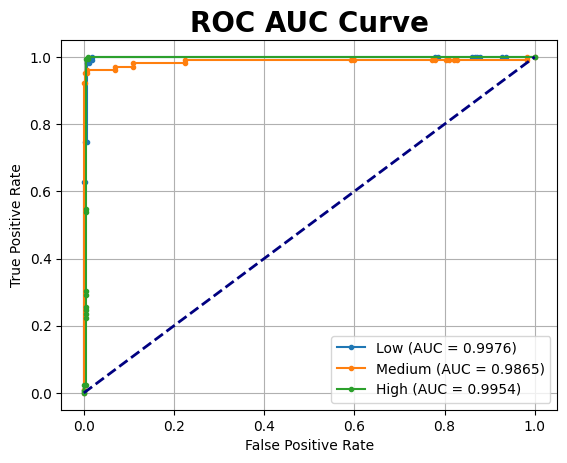

In [59]:
#ROC curve and area for the basic model 
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Predict probabilities for each class using cross-validation
y_pred_proba = cross_val_predict(final_model, X_test_processed, y_test_processed, cv=5, method='predict_proba')

label = ['Low', 'Medium', 'High'] 

# Compute ROC curve and ROC AUC score (One-vs-Rest for multiclass)
for i in range(y_pred_proba.shape[1]):
    fpr_1, tpr_1, _ = roc_curve(y_test_processed == i, y_pred_proba[:, i])
    auc_1 = roc_auc_score(y_test_processed == i, y_pred_proba[:, i])
    plt.plot(fpr_1, tpr_1, marker='.', label=f'{label[i]} (AUC = {auc_1:.4f})')
    print('AUC = {:.4f}'.format(auc_1))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('ROC AUC Curve', fontsize=20, fontweight='bold')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc ='lower right')
plt.grid(True)
plt.legend()
plt.show()


# Chapter 5 - Fine Tuning
This chapter involves:
1. [Fine Tune with GridSearch](#gridsearch)
    - `penalty`
        1. `l1`
        2. `l2`
    - `C (regularization strength)`
    - `solver`
        1. `liblinear`
        2. `lbfgs`
        3. `newton-cg`
    - `max_iter`
    - `class_weight`
        
2. [Evaluation of the fine-tuned model](#evaluation-of-fine-tuned-model)
    - Classification Report
    - Confusion Matrix
    - ROC-AUC graph

## GridSearch for solvers that supporting l1 and l2 penality 

In [60]:
#Fine Tuning

#GridSearch for liblinear solver
from sklearn.model_selection import GridSearchCV

# Define the model
log_reg_testing = OneVsRestClassifier(LogisticRegression())

# Define the parameter grid
param_grid = {
    'estimator__penalty': ['l1','l2'],  # L1 and L2 regularization
    'estimator__C': [0.01, 0.1],  # Regularization strength
    'estimator__solver': ['liblinear'],  # Solvers that support L1 and L2
    'estimator__max_iter': [5000, 6000],  # Higher maximum iterations
    'estimator__class_weight': [None, 'balanced']
}

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=log_reg_testing, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the model to the data
grid_search.fit(X_train_processed, y_train_processed)

# Get the best parameters
print("Best parameters found: ", grid_search.best_params_)

# Get the best estimator
best_model = grid_search.best_estimator_


Best parameters found:  {'estimator__C': 0.1, 'estimator__class_weight': 'balanced', 'estimator__max_iter': 5000, 'estimator__penalty': 'l1', 'estimator__solver': 'liblinear'}


## Evaluation of Fine Tuned Model

In [61]:
tuned_pred = best_model.predict(X_test_processed)

tuned_accuracy:float = accuracy_score(y_test_processed, tuned_pred)
tuned_f1:float = f1_score(y_test_processed, tuned_pred, average='weighted')
tuned_recall:float = recall_score(y_test_processed, tuned_pred, average='weighted')
tuned_precision:float = precision_score(y_test_processed, tuned_pred, average='weighted')

#display the result
print("Tuned Metrices: ")
print(f'Accuracy: {tuned_accuracy}')
print(f'Precision: {tuned_precision}')
print(f'Recall: {tuned_recall}')
print(f'F1 score: {tuned_f1}')

Tuned Metrices: 
Accuracy: 0.9588688946015425
Precision: 0.9587566009377995
Recall: 0.9588688946015425
F1 score: 0.9588035813341302


### Classification Report

In [72]:
from sklearn.metrics import classification_report
# Classification report for the test set
report = classification_report(y_test_processed, tuned_pred, target_names=['low', 'medium', 'high'])
print(report)

              precision    recall  f1-score   support

         low       0.99      0.98      0.99       110
      medium       0.98      0.98      0.98       104
        high       0.99      1.00      1.00       175

    accuracy                           0.99       389
   macro avg       0.99      0.99      0.99       389
weighted avg       0.99      0.99      0.99       389



### Confusion Matrix

<Figure size 1200x800 with 0 Axes>

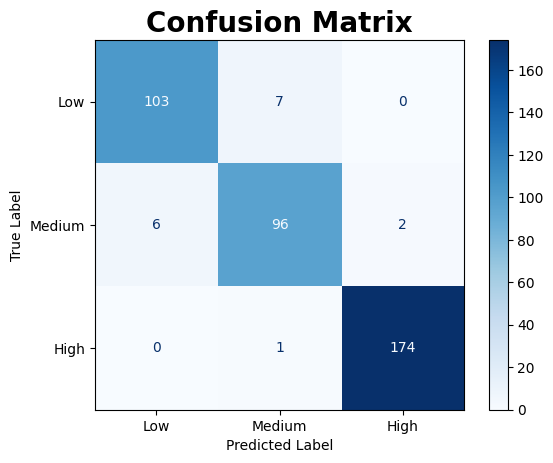

In [62]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_test_processed, tuned_pred, labels=[0.0, 1.0, 2.0])
plt.figure(figsize=(12, 8))

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Low", "Medium", "High"])
disp.plot(cmap=plt.cm.Blues)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix', fontsize=20, fontweight='bold')
plt.show()

### AUC-ROC

AUC = 0.9854
AUC = 0.7796
AUC = 0.9855


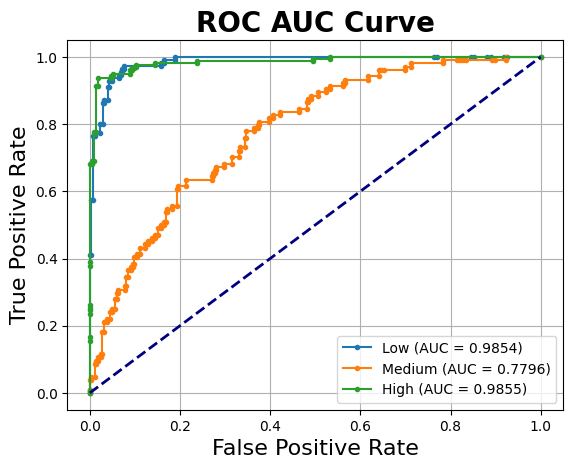

In [63]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

y_pred_proba = cross_val_predict(best_model, X_test_processed, y_test_processed, cv=5, method='predict_proba')

label = ['Low', 'Medium', 'High'] 

for i in range(y_pred_proba.shape[1]):
    fpr_1, tpr_1, _ = roc_curve(y_test_processed == i, y_pred_proba[:, i])
    auc_1 = roc_auc_score(y_test_processed == i, y_pred_proba[:, i])
    plt.plot(fpr_1, tpr_1, marker='.', label=f'{label[i]} (AUC = {auc_1:.4f})')
    print('AUC = {:.4f}'.format(auc_1))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('ROC AUC Curve', fontsize=20, fontweight='bold')
plt.xlabel('False Positive Rate', fontsize = 16)
plt.ylabel('True Positive Rate', fontsize =16)

plt.legend(loc ='lower right')
plt.grid(True)
plt.show()

## GridSearch for solvers that supporting l2 penality 

In [66]:
#GridSearch for lbfgs solver
from sklearn.model_selection import GridSearchCV

# Define the model
log_reg_testing = OneVsRestClassifier(LogisticRegression())

# Define the parameter grid
param_grid = {
    'estimator__penalty': ['l2'],  # L2 regularization
    'estimator__C': [0.01, 0.1],  # Regularization strength
    'estimator__solver': ['lbfgs', 'newton-cg'],  # Solvers that support L2
    'estimator__max_iter': [5000, 6000],  # Higher maximum iterations
    'estimator__class_weight': [None, 'balanced']
}

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=log_reg_testing, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the model to the data
grid_search.fit(X_train_processed, y_train_processed)

# Get the best parameters
print("Best parameters found: ", grid_search.best_params_)

# Get the best estimator
best_model = grid_search.best_estimator_


Best parameters found:  {'estimator__C': 0.1, 'estimator__class_weight': 'balanced', 'estimator__max_iter': 5000, 'estimator__penalty': 'l2', 'estimator__solver': 'lbfgs'}


## Evaluation of Fine Tuned Model

In [67]:
tuned_pred = best_model.predict(X_test_processed)

tuned_accuracy:float = accuracy_score(y_test_processed, tuned_pred)
tuned_f1:float = f1_score(y_test_processed, tuned_pred, average='weighted')
tuned_recall:float = recall_score(y_test_processed, tuned_pred, average='weighted')
tuned_precision:float = precision_score(y_test_processed, tuned_pred, average='weighted')

#display the result
print("Testing Metrices: ")
print(f'Accuracy: {tuned_accuracy}')
print(f'Precision: {tuned_precision}')
print(f'Recall: {tuned_recall}')
print(f'F1 score: {tuned_f1}')

Testing Metrices: 
Accuracy: 0.9897172236503856
Precision: 0.9897082455173656
Recall: 0.9897172236503856
F1 score: 0.9897032781140256


### Classification report

In [73]:
from sklearn.metrics import classification_report
# Classification report for the test set
report = classification_report(y_test_processed, tuned_pred, target_names=['low', 'medium', 'high'])
print(report)

              precision    recall  f1-score   support

         low       0.99      0.98      0.99       110
      medium       0.98      0.98      0.98       104
        high       0.99      1.00      1.00       175

    accuracy                           0.99       389
   macro avg       0.99      0.99      0.99       389
weighted avg       0.99      0.99      0.99       389



### Confusion Matrix

<Figure size 1200x800 with 0 Axes>

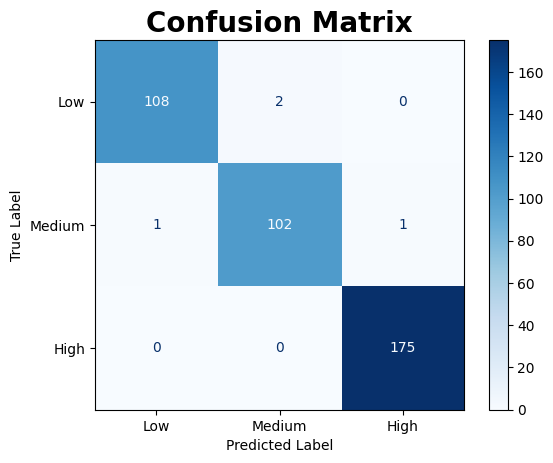

In [68]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix


# Compute confusion matrix
cm = confusion_matrix(y_test_processed, tuned_pred, labels=[0.0, 1.0, 2.0])
plt.figure(figsize=(12, 8))

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm , display_labels=["Low", "Medium", "High"])
disp.plot(cmap=plt.cm.Blues)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix', fontsize=20, fontweight='bold')
plt.show()

### AUC-ROC

AUC = 0.9984
AUC = 0.9915
AUC = 0.9981


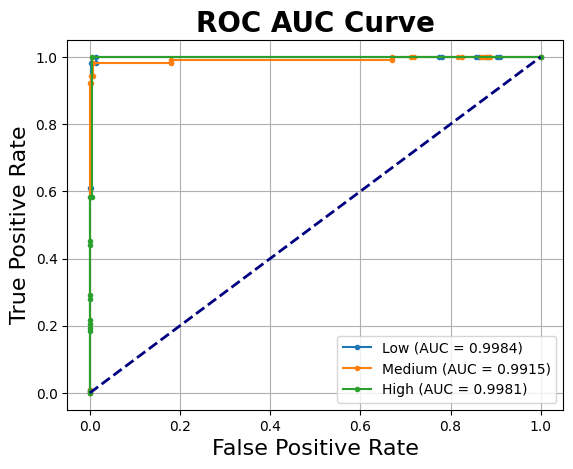

In [69]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

y_pred_proba = cross_val_predict(best_model, X_test_processed, y_test_processed, cv=5, method='predict_proba')

label = ['Low', 'Medium', 'High'] 

for i in range(y_pred_proba.shape[1]):
    fpr_1, tpr_1, _ = roc_curve(y_test_processed == i, y_pred_proba[:, i])
    auc_1 = roc_auc_score(y_test_processed == i, y_pred_proba[:, i])
    plt.plot(fpr_1, tpr_1, marker='.', label=f'{label[i]} (AUC = {auc_1:.4f})')
    print('AUC = {:.4f}'.format(auc_1))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('ROC AUC Curve', fontsize=20, fontweight='bold')
plt.xlabel('False Positive Rate', fontsize = 16)
plt.ylabel('True Positive Rate', fontsize =16)

plt.legend(loc ='lower right')
plt.grid(True)
plt.show()